In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import torch
import torch.nn as nn
from collections import defaultdict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [14]:
os.chdir(r"C:\Users\TOMLU\Desktop\Data3888\individual")

In [15]:
cbr = pd.read_csv("metadata_code/cbr.csv")
meta = pd.read_excel("metadata_code/41467_2023_43458_MOESM4_ESM.xlsx", sheet_name=1)
image_dir = "images/100" 
output_base = "images/images_4fold"

In [16]:
# Merge cell ID and annotation
meta["index"] = meta.index + 1  # Ensure cell_id matches index
print(meta.head())
df = pd.merge(cbr.drop_duplicates("index"), meta[["index", "Cluster"]], on="index")

# Get image space midpoint and divide into quadrants
x_mid = df["axis-1"].median()
y_mid = df["axis-0"].median()

def get_quadrant(row):
    if row["axis-1"] < x_mid and row["axis-0"] < y_mid:
        return "Q1"  # Top-left
    elif row["axis-1"] >= x_mid and row["axis-0"] < y_mid:
        return "Q2"  # Top-right
    elif row["axis-1"] < x_mid and row["axis-0"] >= y_mid:
        return "Q3"  # Bottom-left
    else:
        return "Q4"  # Bottom-right

df["quadrant"] = df.apply(get_quadrant, axis=1)

# Copy images to corresponding quadrant subfolders
for _, row in df.iterrows():
    cluster = row["Cluster"].replace("&", "and").replace(" ", "_")
    quadrant = row["quadrant"]
    src_path = os.path.join(image_dir, cluster, f"cell_{row['index']}_100.png")
    dst_folder = os.path.join(output_base, quadrant, cluster)
    os.makedirs(dst_folder, exist_ok=True)
    dst_path = os.path.join(dst_folder, f"cell_{row['index']}_100.png")
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

   Barcode  UMAP_DIM1  UMAP_DIM2         Cluster  transcript_counts  \
0        1        NaN        NaN          DCIS 2                 28   
1        2        NaN        NaN          DCIS 2                 94   
2        3  -1.795124   9.981263       Unlabeled                  9   
3        4        NaN        NaN  Invasive_Tumor                 11   
4        5        NaN        NaN          DCIS 2                 48   

   x_centroid  y_centroid  gene_counts  index  
0  847.259912  326.191365           15      1  
1  826.341995  328.031830           38      2  
2  848.766919  331.743187            8      3  
3  824.228409  334.252643            9      4  
4  841.357538  332.242505           33      5  


In [17]:
# Define the images_4fold directory path
base_dir = "images/images_4fold"

# Check if the directory exists
if not os.path.exists(base_dir):
    print(f"Error: {base_dir} directory does not exist")
else:
    print(f"Found directory: {base_dir}")

Found directory: images/images_4fold


In [18]:
quadrants = ['Q1', 'Q2', 'Q3', 'Q4']

cell_group_map = {
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",

    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

    # Unlabeled
    "Unlabeled": "Unlabeled"
}

In [19]:
image_records = []

for quad in quadrants:
    quad_path = os.path.join(base_dir, quad)
    if not os.path.exists(quad_path):
        continue

    for cluster in os.listdir(quad_path):
        cluster_path = os.path.join(quad_path, cluster)
        if not os.path.isdir(cluster_path):
            continue

        group = cell_group_map.get(cluster, "Unlabeled")
        binary_group = "tumor" if group in ["Tumor", "Early stage cancer"] else "non-tumor"

        for file in os.listdir(cluster_path):
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_records.append({
                    "file_path": os.path.join(cluster_path, file),
                    "cluster": cluster,
                    "Quadrant": quad,
                    "Binary Group": binary_group
                })

df_all = pd.DataFrame(image_records)

In [20]:
def stratified_sample(df, group_name, total_samples=1000):
    df_group = df[df["Binary Group"] == group_name]
    clusters = df_group["cluster"].unique()
    samples_per_cluster = total_samples // len(clusters)

    sampled = df_group.groupby("cluster").apply(
        lambda x: x.sample(n=min(samples_per_cluster, len(x)), random_state=42)
    ).reset_index(drop=True)

    if len(sampled) < total_samples:
        remaining = df_group[~df_group.index.isin(sampled.index)]
        to_add = total_samples - len(sampled)
        if len(remaining) >= to_add:
            sampled = pd.concat([
                sampled,
                remaining.sample(n=to_add, random_state=42)
            ], ignore_index=True)

    return sampled

tumor_sample = stratified_sample(df_all, "tumor", 1000)
non_tumor_sample = stratified_sample(df_all, "non-tumor", 1000)

df_sampled = pd.concat([tumor_sample, non_tumor_sample]).reset_index(drop=True)

In [33]:
df_sampled["Quadrant"].value_counts()

Quadrant
Q3    572
Q2    550
Q4    440
Q1    438
Name: count, dtype: int64

In [21]:
# Count number of images per cluster in tumor_sample
print("Cell counts in Tumor Sample:")
print(tumor_sample["cluster"].value_counts())

# Count number of images per cluster in non_tumor_sample
print("\nCell counts in Non-Tumor Sample:")
print(non_tumor_sample["cluster"].value_counts())

Cell counts in Tumor Sample:
cluster
DCIS_1                   250
DCIS_2                   250
Invasive_Tumor           250
Prolif_Invasive_Tumor    250
Name: count, dtype: int64

Cell counts in Non-Tumor Sample:
cluster
Stromal                      65
Macrophages_1                64
B_Cells                      63
CD4+_T_Cells                 63
CD8+_T_Cells                 63
Endothelial                  62
IRF7+_DCs                    62
LAMP3+_DCs                   62
Macrophages_2                62
Mast_Cells                   62
Myoepi_ACTA2+                62
Myoepi_KRT15+                62
Perivascular-Like            62
Stromal_and_T_Cell_Hybrid    62
T_Cell_and_Tumor_Hybrid      62
Unlabeled                    62
Name: count, dtype: int64


In [22]:
train_df = df_sampled[df_sampled["Quadrant"].isin(["Q1", "Q2", "Q3"])].copy()
test_df  = df_sampled[df_sampled["Quadrant"] == "Q4"].copy()

In [24]:
# Define a custom PyTorch Dataset

# Image transform: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  
])

# Custom dataset class
class CellDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "file_path"]
        label = 1 if self.df.loc[idx, "Binary Group"] == "tumor" else 0

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [25]:
# Create DataLoaders

# Dataset and DataLoader
train_dataset = CellDataset(train_df, transform=transform)
test_dataset = CellDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
# Define a simple CNN model

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # → 16x100x100
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 16x50x50

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # → 32x50x50
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → 32x25x25
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 25 * 25, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.squeeze(1)


In [27]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 34.6989
Epoch 2, Loss: 33.9947
Epoch 3, Loss: 33.8631
Epoch 4, Loss: 33.8195
Epoch 5, Loss: 29.2158


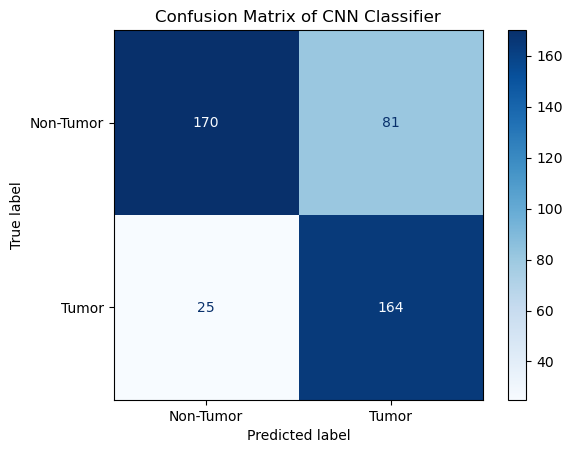

In [30]:
# Evaluate the model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval() 
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = (outputs > 0.5).int().cpu().numpy()  
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Tumor", "Tumor"])


disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix of CNN Classifier")
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the predictions and true labels to NumPy arrays
y_pred = np.array(all_preds)
y_true = np.array(all_labels)

# Calculate common evaluation metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7591
Precision: 0.6694
Recall:    0.8677
F1 Score:  0.7558


In [ ]:
# The CNN model achieved an accuracy of 75.91%, indicating overall solid performance. It reached a recall of 86.77%, showing strong ability to detect tumor cases. However, the precision was 68.94%, suggesting some false positives. The F1 score of 75.58% reflects a balanced trade-off between precision and recall.